# Import library

In [6]:

from En_system_intergrated import *
from SALib.sample import saltelli
from SALib.analyze import sobol
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dartwork_mpl as dm
import calc_util as cu
import seaborn as sns
from scipy.stats import norm, uniform, triang, gamma
import warnings
from pprint import pprint
warnings.filterwarnings("ignore")

dm.use_style('dmpl_light')
# plt.rcParams['font.family'] = 'Roboto'

Load colors...
Load colormaps...


# Primary energy use, CO2 emission, Exergy efficiency

## EB, GB, HPB

In [4]:
EB  = ElectricBoiler()
GB  = GasBoiler()
HPB = HeatPumpBoiler()
EB.system_update()
GB.system_update()
HPB.system_update()

# Primary energy factor
PEF_elec = 2.75 
PEF_NG = 1.1

# CO2 emission factor
Wh2MJ = 10**6/(1*cu.h2s) # cu.h2s = 3600 s/h
C_to_CO2 = 44/12 # 탄소 배출량당 이산화탄소 배출량 분자량에 의한 환산계수 
CF_NG_ori = 15.281 # tC/TJ = kgC/GJ = gC/MJ

CF_elec = 0.4747 # tCO2/MWh = gCO2/Wh
CF_NG = (CF_NG_ori*C_to_CO2)/Wh2MJ # gCO2/Wh

# Energy use
energy_use = [
        EB.energy_balance['hot water tank']['in']['$E_{heater}$'],
        GB.energy_balance['combustion chamber']['in']['$E_{NG}$'],
        HPB.energy_balance['refrigerant loop']['in']['$E_{cmp}$'] + HPB.energy_balance['external unit']['in']['$E_{fan}$']
]

# Exergy use
exergy_use = [
        EB.exergy_balance['hot water tank']['in']['$E_{heater}$'],
        GB.exergy_balance['combustion chamber']['in']['$X_{NG}$'],
        HPB.exergy_balance['refrigerant loop']['in']['$E_{cmp}$'] + HPB.exergy_balance['external unit']['in']['$E_{fan}$']
]

# Primary energy use
primary_energy_use = [
        energy_use[0] * PEF_elec,
        energy_use[1] * PEF_NG,
        energy_use[2] * PEF_elec,
]

# CO2 emission
CO2_emission = [
        energy_use[0] * CF_elec, 
        energy_use[1] * CF_NG,
        energy_use[2] * CF_elec
]

eX_consum = [
        calculate_total_exergy_consumption(EB.exergy_balance),
        calculate_total_exergy_consumption(GB.exergy_balance),
        calculate_total_exergy_consumption(HPB.exergy_balance),
]

eX_efficiency = [
        EB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[0]*100,
        GB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[1]*100,
        HPB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[2]*100
]

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(16), dm.cm2in(3.5)), dpi=200, facecolor=None, edgecolor='k')

for ridx in range(nrows):
    for cidx in range(ncols):
        idx    = ridx * ncols + cidx
        data   = [energy_use, primary_energy_use, CO2_emission, eX_efficiency][idx]
        heading   = ['Energy use [W]', 'Primary energy use [W]', 'CO$_2$ emission [gCO$_2$/h]', 'Exergy efficiency [%]'][idx]
        labels = [['EB', 'GB', 'HPB'], # ['EB\n$(E_{heater}$)', 'GB\n$(E_{NG})$', 'HPB\n$(E_{fan} + E_{cmp})$']
                  ['EB', 'GB', 'HPB'],
                  ['EB', 'GB', 'HPB'],
                  ['EB', 'GB', 'HPB']][idx]

        group_margin = 0.15  # margin between groups
        bar_margin   = 0.1  # margin between bars
        bar_width    = 0.25

        dN     = len(data)  # number of data
        x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)]) # 바 margin과 bar width를 곱해서 그룹 마진이 없는 x_pos0에 저장
        gl1    = [[1,1,1],[1,1,1],[1,1,1],[1,1,1]][idx]  # group
        gN     = len(gl1)  # number of groups
        gl2    = np.cumsum(gl1)

        x_pos = x_pos0[:gl2[0]].tolist()
        for i in range(gN - 1):  # Add group_margin between arrays
            x_pos.extend((x_pos0[gl2[i]:gl2[i+1]] + group_margin * (i + 1)).tolist()) # 그룹 마진을 추가

        # Plot parameters
        sp_ratio = 0.5
        xmar = bar_width
        xmax = max(x_pos)
        xmin = min(x_pos)
        ymar = 0
        ymax = [9000, 9000, 1500, 30][idx]
        ymin = [0, 0, 0, 0][idx]
        yint = [3000, 3000, 500, 10][idx]

        # Create vertical bars
        bars = ax[idx].bar(x_pos, data, bar_width, color=[['dm.red7', 'dm.red5','dm.red3'],
                                                          ['dm.orange7', 'dm.orange5','dm.orange3'],
                                                          ['dm.green7', 'dm.green5','dm.green3'],
                                                          ['dm.grape7', 'dm.grape5','dm.grape3']][idx])

        # Annotation
        ax[idx].annotate(f'{heading}', xy=(0.5, 1.1), xycoords='axes fraction', color='dm.gray9',
                        horizontalalignment='center', verticalalignment='bottom', fontsize=dm.fs(0), fontweight=400)

        # Add value labels on top of each bar
        for bidx, bar in enumerate(bars):
            height = bar.get_height()
            if cidx < 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                        f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-2))
            elif cidx == 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=dm.fs(-2))
            
        # Axes limits
        ax[idx].set_xlim(xmin - xmar, xmax + xmar)
        ax[idx].set_ylim(ymin - ymar, ymax + ymar)


        # Tick parameters
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                            which='major', length=0, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                            which='minor', length=0, width=0.25 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-1.5),
                            which='major', length=2, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-1.5),
                            which='minor', length=1, width=0.25 * sp_ratio, pad=3)

        # Labels and ticks
        ax[idx].set_xticks(x_pos)
        ax[idx].set_yticks(np.arange(ymin,ymax+yint,yint))  # No y-ticks
        ax[idx].set_xticklabels(labels, ha='center', fontsize=dm.fs(-1.5), fontweight='regular')
        ax[idx].set_yticklabels(np.arange(ymin,ymax+yint,yint), fontsize=dm.fs(-1.5), fontweight='regular')
        
        # Minor ticks
        ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

        # Spines
        for k in ['top','right']:  # Only keep bottom spine
            ax[idx].spines[k].set_visible(False)
        ax[0].spines['bottom'].set_linewidth(0.5 * sp_ratio)
        ax[0].spines['bottom'].set_color('k')

plt.subplots_adjust(wspace=0.3)
dm.simple_layout(fig, bbox=(0.01,1,0.0,.945), verbose=False)
# img_stem = f'../figure/heat_pump_boiler_exergy_results'
# plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)


## GB, HPB

In [5]:
EB  = ElectricBoiler()
GB  = GasBoiler()
HPB = HeatPumpBoiler()
EB.system_update()
GB.system_update()
HPB.system_update()

# Primary energy factor
PEF_elec = 2.75 
PEF_NG = 1.1

# CO2 emission factor
Wh2MJ = 10**6/(1*cu.h2s) # cu.h2s = 3600 s/h
C_to_CO2 = 44/12 # 탄소 배출량당 이산화탄소 배출량 분자량에 의한 환산계수 
CF_NG_ori = 15.281 # tC/TJ = kgC/GJ = gC/MJ

CF_elec = 0.4747 # tCO2/MWh = gCO2/Wh
CF_NG = (CF_NG_ori*C_to_CO2)/Wh2MJ # gCO2/Wh

# Energy use
energy_use = [
    GB.energy_balance['combustion chamber']['in']['$E_{NG}$'],
    HPB.energy_balance['refrigerant loop']['in']['$E_{cmp}$'] + HPB.energy_balance['external unit']['in']['$E_{fan}$']
]

# Exergy use
exergy_use = [
    GB.exergy_balance['combustion chamber']['in']['$X_{NG}$'],
    HPB.exergy_balance['refrigerant loop']['in']['$E_{cmp}$'] + HPB.exergy_balance['external unit']['in']['$E_{fan}$']
]

# Primary energy use
primary_energy_use = [
    energy_use[0] * PEF_NG,
    energy_use[1] * PEF_elec,
]

# CO2 emission
CO2_emission = [
    energy_use[0] * CF_NG,
    energy_use[1] * CF_elec
]

eX_consum = [
    calculate_total_exergy_consumption(GB.exergy_balance),
    calculate_total_exergy_consumption(HPB.exergy_balance),
]

eX_efficiency = [
    GB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[0]*100,
    HPB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[1]*100
]

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(12), dm.cm2in(3.5)), dpi=200, facecolor=None, edgecolor='k')

for ridx in range(nrows):
    for cidx in range(ncols):
        idx    = ridx * ncols + cidx
        data   = [energy_use, primary_energy_use, CO2_emission, eX_efficiency][idx]
        heading   = ['Energy use [W]', 'Primary energy use [W]', 'CO$_2$ emission [gCO$_2$/h]', 'Exergy efficiency [%]'][idx]
        labels = [['GB', 'HPB'], 
            ['GB', 'HPB'],
            ['GB', 'HPB'],
            ['GB', 'HPB']][idx]

        group_margin = 0  # margin between groups
        bar_margin   = 0.05  # margin between bars
        bar_width    = 0.25

        dN     = len(data)  # number of data
        x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)]) # 바 margin과 bar width를 곱해서 그룹 마진이 없는 x_pos0에 저장
        gl1    = [[1,1],[1,1],[1,1],[1,1]][idx]  # group
        gN     = len(gl1)  # number of groups
        gl2    = np.cumsum(gl1)

        x_pos = x_pos0[:gl2[0]].tolist()
        for i in range(gN - 1):  # Add group_margin between arrays
            x_pos.extend((x_pos0[gl2[i]:gl2[i+1]] + group_margin * (i + 1)).tolist()) # 그룹 마진을 추가

        # Plot parameters
        sp_ratio = 0.5
        xmar = bar_width
        xmax = max(x_pos)
        xmin = min(x_pos)
        ymar = 0
        ymax = [4000, 4000, 800, 30][idx]
        ymin = [0, 0, 0, 0][idx]
        yint = [1000, 1000, 200, 10][idx]

        # Create vertical bars
        bars = ax[idx].bar(x_pos, data, bar_width, color=[['dm.red7', 'dm.red5'],
                                ['dm.orange7', 'dm.orange5'],
                                ['dm.green7', 'dm.green5'],
                                ['dm.grape7', 'dm.grape5']][idx])

        # Annotation
        ax[idx].annotate(f'{heading}', xy=(0.5, 1.1), xycoords='axes fraction', color='dm.gray9',
                horizontalalignment='center', verticalalignment='bottom', fontsize=dm.fs(-1), fontweight=400)

        # Add value labels on top of each bar
        for bidx, bar in enumerate(bars):
            height = bar.get_height()
            if cidx < 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-2), fontweight = 300)
            elif cidx == 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                f'{height:.1f}', ha='center', va='bottom', fontsize=dm.fs(-2), fontweight = 300)
            
        # Axes limits
        ax[idx].set_xlim(xmin - xmar, xmax + xmar)
        ax[idx].set_ylim(ymin - ymar, ymax + ymar)


        # Tick parameters
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                    which='major', length=0, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                    which='minor', length=0, width=0.25 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='out', labelsize=dm.fs(-1.5),
                    which='major', length=2, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='out', labelsize=dm.fs(-1.5),
                    which='minor', length=0, width=0.25 * sp_ratio, pad=3)

        # Labels and ticks
        ax[idx].set_xticks(x_pos)
        ax[idx].set_yticks(np.arange(ymin,ymax+yint,yint))  # No y-ticks
        ax[idx].set_xticklabels(labels, ha='center', fontsize=dm.fs(-1.5), fontweight=300)
        ax[idx].set_yticklabels(np.arange(ymin,ymax+yint,yint), fontsize=dm.fs(-1.5), fontweight= 300)
        
        # Minor ticks
        ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

        # Spines
        for k in ['top','right']:  # Only keep bottom spine
            ax[idx].spines[k].set_visible(False)
        ax[0].spines['bottom'].set_linewidth(0.5 * sp_ratio)
        ax[0].spines['bottom'].set_color('k')

plt.subplots_adjust(wspace=0.4)
dm.simple_layout(fig, bbox=(0.01,1,0.0,1), verbose=False)
img_stem = r'C:\betlab\00 Papers, Conferences\01 Conferences\2025\AIK 춘계학술발표\DHW exergy analysis_HB\figure\GB&HPB_results'
plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)


# Monte Carlo simulation

## EB

In [3]:
# 시뮬레이션 반복 횟수
num_simulations = 10000

# 문제 정의
problem = {
    'num_vars': 3,
    'names'   : ['Insulation thick [m]', 'Outdoor air temp [°C]', "Supply water temp [°C]"],
    'bounds'  : [
        [0.01, 0.1],    # x_ins      : 단열 두께 (m)
        [cu.C2K(-10), cu.C2K(10)]        ,    # T_oa: 실외 온도 (°C)
        [cu.C2K(4), cu.C2K(10)]       ,    # T_sw: 상수도 온도 (°C)
    ],
    'dists': ['unif', 'unif', 'unif']  # 분포 형상 (균등, 삼각, 정규)
}

# Saltelli 방법을 사용하여 샘플 생성
param_values = saltelli.sample(problem, num_simulations)

# 엑서지 효율 저장 리스트
ex_eff_EB = []

# 몬테카를로 시뮬레이션 및 엑서지 효율 계산
for i in range(param_values.shape[0]):  
    # ElectricBoiler 객체 생성
    boiler = ElectricBoiler()

    # 확률 변수에서 추출한 변수 값들 할당
    boiler.x_ins              = param_values[i, 0]  
    boiler.T0                 = param_values[i, 1] 
    boiler.T_w_sup            = param_values[i, 2] 

    # 시스템 업데이트 수행
    boiler.system_update()

    # 엑서지 효율 계산
    X_w_serv = boiler.exergy_balance["mixing valve"]["out"]["$X_{w,serv}$"]
    E_heater = boiler.exergy_balance["hot water tank"]["in"]["$E_{heater}$"]

    eta_exergy = X_w_serv / E_heater
    # print(eta_exergy)
    ex_eff_EB.append(eta_exergy)
    
    if eta_exergy < 0:
        print(f"h_co: {boiler.h_co}, eta_exergy: {eta_exergy}")

# 데이터 시각화
nrows = 1
ncols = 1

xmin, xmax, xint, xmar = 0, 15, 3, 0
ymin, ymax, yint, ymar = 0, 0.2,  0.05,  0

fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(10), dm.cm2in(5)), dpi=600)
for ridx in range(nrows): 
    for cidx in range(ncols): 
        idx = ridx * ncols + cidx

        # Plot histogram
        sns.kdeplot(np.array(ex_eff_EB) * 100, ax=ax, color='tw.indigo:700', fill=True, linewidth=0.75)

        # tick limits 
        ax.set_xlim(xmin - xmar, xmax + xmar)
        ax.set_ylim(ymin - ymar, ymax + ymar)
        
        # set ticks
        ax.set_xticks(np.arange(xmin, xmax + xint*0.9, xint))
        ax.set_yticks(np.arange(ymin, ymax + yint, yint))
        
        # print x, y range
        # print(f"y max: {max_frequency}")
        
# set tick parameters
plt.xlabel("Exergy efficiency [%]", fontsize=dm.fs(0), fontweight=300)
plt.ylabel("Probability density", fontsize=dm.fs(0), fontweight=300)

# layout
dm.simple_layout(fig, bbox=(0, 1, 0.01, 1), verbose=False)

# save
fig_name = 'ex_eff_distribution_EB'
folder_path = r'figure'
fig.savefig(f'{folder_path}/{fig_name}.png', dpi=600)

# show
dm.util.save_and_show(fig)
plt.close()

# print
print(f"Exergy efficiency range: {min(ex_eff_EB)*100:.2f} ~ {max(ex_eff_EB)*100:.2f}")
print(f"\n\n{'='*10} Problem setting {'='*10}\n")
pprint(problem)

Exergy efficiency range: 4.74 ~ 14.20


========== Problem setting ==========

{'bounds': [[0.01, 0.1], [263.15, 283.15], [277.15, 283.15]],
 'dists': ['unif', 'unif', 'unif'],
 'names': ['Insulation thick [m]',
           'Outdoor air temp [°C]',
           'Supply water temp [°C]'],
 'num_vars': 3,
 'sample_scaled': True}


## GB

In [12]:
# 시뮬레이션 반복 횟수
num_simulations = 10000

# 문제 정의
problem = {
    'num_vars': 4,
    'names'   : ['Insulation thick [m]', 'Outdoor air temp [°C]', "Supply water temp [°C]", "boiler eff [-]"],
    'bounds'  : [
        [0.01, 0.1],    # x_ins      : 단열 두께 (m)
        [cu.C2K(-10), cu.C2K(10)],    # T_oa: 실외 온도 (°C)
        [cu.C2K(4), cu.C2K(10)],    # T_sw: 상수도 온도 (°C)
        [0.8, 0.9],    # COP: COP
    ],
    'dists': ['unif', 'unif', 'unif', 'unif']  
}

# Saltelli 방법을 사용하여 샘플 생성
param_values = saltelli.sample(problem, num_simulations)

# 엑서지 효율 저장 리스트
ex_eff_GB = []

# 몬테카를로 시뮬레이션 및 엑서지 효율 계산
for i in range(param_values.shape[0]):  
    # ElectricBoiler 객체 생성
    boiler = GasBoiler()

    # 확률 변수에서 추출한 변수 값들 할당
    boiler.x_ins              = param_values[i, 0]  # 단열 두께
    boiler.T0                 = param_values[i, 1]  # 대류 열전달 계수
    boiler.T_w_sup            = param_values[i, 2]  # 상수도 온도
    boiler.eta_boiler         = param_values[i, 3]  # 보일러 효율

    # 시스템 업데이트 수행
    boiler.system_update()

    # 엑서지 효율 계산
    X_w_serv = boiler.exergy_balance["mixing valve"]["out"]["$X_{w,serv}$"]
    X_NG = boiler.exergy_balance["combustion chamber"]["in"]["$X_{NG}$"]
    
    eta_exergy = X_w_serv / X_NG
    ex_eff_GB.append(eta_exergy)

# 데이터 시각화
nrows = 1
ncols = 1

xmin, xmax, xint, xmar = 0, 15, 3, 0
ymin, ymax, yint, ymar = 0, 0.2,  0.05,  0

fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(10), dm.cm2in(5)), dpi=600)
for ridx in range(nrows): 
    for cidx in range(ncols): 
        idx = ridx * ncols + cidx

        # Plot histogram
        sns.kdeplot(np.array(ex_eff_GB) * 100, ax=ax, color='tw.indigo:700', fill=True, linewidth=0.75)

        # tick limits 
        ax.set_xlim(xmin - xmar, xmax + xmar)
        ax.set_ylim(ymin - ymar, ymax + ymar)
        
        # set ticks
        ax.set_xticks(np.arange(xmin, xmax + xint*0.9, xint))
        ax.set_yticks(np.arange(ymin, ymax + yint, yint))
        
        # print x, y range
        # print(f"y max: {max_frequency}")

# set tick parameters
plt.xlabel("Exergy efficiency [%]", fontsize=dm.fs(0), fontweight=300)
plt.ylabel("Probability density", fontsize=dm.fs(0), fontweight=300)

# layout
dm.simple_layout(fig, bbox=(0, 1, 0.01, 1), verbose=False)

# save
fig_name = 'ex_eff_distribution_GB'
folder_path = r'figure'
fig.savefig(f'{folder_path}/{fig_name}.png', dpi=600)

# show
dm.util.save_and_show(fig)
plt.close()

# print
print(f"Exergy efficiency range: {min(ex_eff_GB)*100:.2f} ~ {max(ex_eff_GB)*100:.2f}")
print(f"\n\n{'='*10} Problem setting {'='*10}\n")
pprint(problem)

Exergy efficiency range: 4.23 ~ 13.73


========== Problem setting ==========

{'bounds': [[0.01, 0.1], [263.15, 283.15], [277.15, 283.15], [0.8, 0.9]],
 'dists': ['unif', 'unif', 'unif', 'unif'],
 'names': ['Insulation thick [m]',
           'Outdoor air temp [°C]',
           'Supply water temp [°C]',
           'boiler eff [-]'],
 'num_vars': 4,
 'sample_scaled': True}


## HPB

In [ ]:
# 시뮬레이션 반복 횟수
num_simulations = 10000

# 문제 정의
problem = {
    'num_vars': 4,
    'names'   : ['Insulation thick [m]',  'Outdoor air temp [°C]', "Supply water temp [°C]", "COP [-]"],
    'bounds'  : [
        [0.01, 0.1],    # x_ins      : 단열 두께 (m)
        [cu.C2K(-10), cu.C2K(10)],    # T_oa: 실외 온도 (°C)
        [cu.C2K(4), cu.C2K(10)],    # T_sw: 상수도 온도 (°C)
        [1.5, 2.5],    # COP: COP
    ],
    'dists': ['unif', 'unif', 'unif', 'unif']  # 분포 형상 (균등, 삼각, 정규)
}

# Saltelli 방법을 사용하여 샘플 생성 -> 최종 샘플 개수는 num_simulations * (num_vars + 2) = 10000 * (5 + 2) = 70000
param_values = saltelli.sample(problem, num_simulations, calc_second_order=True)

# 엑서지 효율 저장 리스트
ex_eff_HPB = []
cop_list = []
T_r_ext_list = []

# 몬테카를로 시뮬레이션 및 엑서지 효율 계산
for i in range(param_values.shape[0]):  
    # ElectricBoiler 객체 생성
    boiler = HeatPumpBoiler()

    # 확률 변수에서 추출한 변수 값들 할당
    boiler.x_ins              = param_values[i, 0]  # 단열 두께
    boiler.T0                 = param_values[i, 1]  # 대류 열전달 계수
    boiler.T_w_sup            = param_values[i, 2]  # 상수도 온도
    
    # COP calculation
    dT = boiler.T_w_tank - boiler.T0 # 온수 탱크 온도와 실외 온도 차이
    boiler.COP_hp             = 5.06-0.05*dT +0.00006*(dT**2) # https://www.notion.so/betlab/Model-based-flexibility-assessment-of-a-residential-heat-pump-pool-1af6947d125d8037a108e85bb6985dee?pvs=4
    cop_list.append(boiler.COP_hp)
    

    # 시스템 업데이트 수행
    boiler.system_update()
    T_r_ext_list.append(boiler.T_r_ext)

    # 엑서지 효율 계산
    X_w_serv = boiler.exergy_balance["mixing valve"]["out"]["$X_{w,serv}$"]
    E_fan    = boiler.exergy_balance["external unit"]["in"]["$E_{fan}$"]
    E_cmp    = boiler.exergy_balance["refrigerant loop"]["in"]["$E_{cmp}$"]
    
    eta_exergy = X_w_serv / (E_fan + E_cmp)
    ex_eff_HPB.append(eta_exergy)

# 데이터 시각화
nrows = 1
ncols = 1

xmin, xmax, xint, xmar = 0, 40, 10, 0
ymin, ymax, yint, ymar = 0, 0.15,  0.05,  0

fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(10), dm.cm2in(5)), dpi=600)
for ridx in range(nrows): 
    for cidx in range(ncols): 
        idx = ridx * ncols + cidx

        # Plot histogram
        sns.kdeplot(np.array(ex_eff_HPB) * 100, ax=ax, color='tw.indigo:700', fill=True, linewidth=0.75)

        # tick limits 
        ax.set_xlim(xmin - xmar, xmax + xmar)
        ax.set_ylim(ymin - ymar, ymax + ymar)
        
        # set ticks
        ax.set_xticks(np.arange(xmin, xmax + xint*0.9, xint))
        ax.set_yticks(np.arange(ymin, ymax + yint, yint))
        
        # print x, y range
        print(f"Exergy efficiency range: {min(ex_eff_HPB)*100:.2f} ~ {max(ex_eff_HPB)*100:.2f}")
        # print(f"y max: {max_frequency}")
        

# set tick parameters
plt.xlabel("Exergy efficiency [%]", fontsize=dm.fs(0), fontweight=300)
plt.ylabel("Probability density", fontsize=dm.fs(0), fontweight=300)

# layout
dm.simple_layout(fig, bbox=(0, 1, 0.01, 1), verbose=False)

# save
fig_name = 'ex_eff_distribution_HPB'
folder_path = r'figure'
fig.savefig(f'{folder_path}/{fig_name}.png', dpi=600)

# show
dm.util.save_and_show(fig)
plt.close()

# print
print(f"Exergy efficiency range: {min(ex_eff_HPB)*100:.2f} ~ {max(ex_eff_HPB)*100:.2f}")
print(f"cop range: {min(cop_list):.2f} ~ {max(cop_list):.2f}")
print(f"\n\n{'='*10} Problem setting {'='*10}\n")
pprint(problem)

# # sobol analysis
# Si = sobol.analyze(problem, np.array(ex_eff_HPB), calc_second_order=True, print_to_console=True)

# # 1차 민감도 지수 출력
# print("\n1차 민감도 지수 (S1):")
# for name, s1 in zip(problem["names"], Si["S1"]):
#     print(f"{name}: {s1:.4f}")

Exergy efficiency range: 11.75 ~ 25.23


T_r_ext: -19.9993896484375, -0.0006103515625
Exergy efficiency range: 11.75 ~ 25.23
cop range: 1.85 ~ 2.71


========== Problem setting ==========

{'bounds': [[0.01, 0.1], [263.15, 283.15], [277.15, 283.15], [1.5, 2.5]],
 'dists': ['unif', 'unif', 'unif', 'unif'],
 'names': ['Insulation thick [m]',
           'Outdoor air temp [°C]',
           'Supply water temp [°C]',
           'COP [-]'],
 'num_vars': 4,
 'sample_scaled': True}


In [6]:
print(f"param_values.shape[0]: {param_values.shape[0]}, Y.shape[0]: {len(ex_eff_HPB)}")

param_values.shape[0]: 100000, Y.shape[0]: 100000


## All
- EB, GB, HPB 코드를 모두 실행하여야 돌아감

In [ ]:
# 데이터 시각화
nrows = 1
ncols = 1

xmin, xmax, xint, xmar = 0, 40, 10, 0
ymin, ymax, yint, ymar = 0, 0.2,  0.05,  0

fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(14), dm.cm2in(7)), dpi=600)


# Plot histogram
sns.kdeplot(np.array(ex_eff_EB) * 100, ax=ax, color='tw.orange:700', fill=True, linewidth=0.75)
sns.kdeplot(np.array(ex_eff_GB) * 100, ax=ax, color='tw.pink:700', fill=True, linewidth=0.75)
sns.kdeplot(np.array(ex_eff_HPB) * 100, ax=ax, color='tw.indigo:700', fill=True, linewidth=0.75)

# tick limits 
ax.set_xlim(xmin - xmar, xmax + xmar)
ax.set_ylim(ymin - ymar, ymax + ymar)

# tick parameters
ax.tick_params(axis='x', labelsize=dm.fs(1), which='major')
ax.tick_params(axis='y', labelsize=dm.fs(1), which='major')

# set ticks
ax.set_xticks(np.arange(xmin, xmax + xint*0.9, xint))
ax.set_yticks(np.arange(ymin, ymax + yint, yint))

# legend 
ax.legend(['Electric boiler', 'Gas boiler', 'Heat pump boiler'], fontsize=dm.fs(0),)

# print x, y range
print(f"Exergy efficiency range: {min(ex_eff_HPB)*100:.2f} ~ {max(ex_eff_HPB)*100:.2f}")
# print(f"y max: {max_frequency}")


plt.xlabel("Exergy efficiency [%]", fontsize=dm.fs(2), fontweight=300 )
plt.ylabel("Probability density", fontsize=dm.fs(2), fontweight=300)
# plt.title("Exergy Efficiency Distribution from Monte Carlo Simulation", fontsize=dm.fs(2), fontweight=400)
dm.simple_layout(fig, bbox=(0, 1, 0.01, 1), verbose=False)
fig_name = 'ex_eff_distribution_all'
folder_path = r'figure'
fig.savefig(f'{folder_path}/{fig_name}.png', dpi=600)
dm.util.save_and_show(fig)
plt.close()

Exergy efficiency range: 11.75 ~ 25.23


# Test

## Casacade plot

### EB

In [ ]:
EB = ElectricBoiler()
EB.system_update()

# sub system names
sub_system = list(EB.exergy_balance)

## Exergy values ========================================
values, labels, flows = [], [], [] 

for sub in sub_system:
    for flow in ['in', 'consumed', 'out']:
        flows.extend([flow for _ in range(len(EB.exergy_balance[sub][flow]))])
        values.extend([dictionary['value'] if flow == "in" else -dictionary['value'] for dictionary in EB.exergy_balance[sub][flow]])
        labels.extend([dictionary['symbol'] for dictionary in EB.exergy_balance[sub][flow]])
values[-1] = abs(values[-1])

# 중복제거    
new_values, new_labels, new_flows = [], [], []
for idx, (target, label, flow) in enumerate(zip(values, labels, flows)):
    if any(abs(val) == abs(target) for val in new_values):  # 절댓값만 비교
        matching_indices = [i for i, val in enumerate(new_values) if abs(val) == abs(target)]
        del new_values[matching_indices[0]]
        del new_labels[matching_indices[0]]
        del new_flows[matching_indices[0]]
    else:
        new_values.append(target)
        new_labels.append(label)
        new_flows.append(flow)

cum_values = np.cumsum(new_values)

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(10), dm.cm2in(5)))

# Common settings
bar_width = 0.4
y_max = 3000
x_padding = 0.4
line_thickness = 0.1
text_padding = y_max * 0.01

# Function to draw connecting lines
def draw_waterfall_lines(ax, x, cum_values, line_thickness):
    for i in range(1, len(x)):
        start = cum_values[i-1]
        ax.plot([x[i-1]-bar_width/2, x[i]+bar_width/2], [start, start], color='dm.gray6', linestyle='-', linewidth=line_thickness)

#  plot
dN = len(new_values)
x = np.arange(dN)
colors = ["tw.blue:500" if val > 0 else "tw.lime:500" for val in new_values]

# Plot bars for 
for i in range(len(x)):
    if i == 0 or i == len(x) - 1: # 첫번째와 마지막 bar는 cumvalue를 bottom으로 설정하지 않음 -> 기본 바 형태로 그림
        ax.bar(x[i], new_values[i], bar_width, color=colors[i])
    else:
        ax.bar(x[i], new_values[i], bar_width, bottom=cum_values[i-1], color=colors[i]) # cumvalue를 bottom으로 설정하여 waterfall 형태로 그림

# Draw connecting lines for 
draw_waterfall_lines(ax, x, cum_values, line_thickness)

# Axis settings
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_yticks([])
ax.set_ylim(0, y_max)

# Set x-axis labels and limits
ax.set_xticks(x)
ax.set_xticklabels(new_labels, ha='center', fontsize=dm.fs(0.5), color = 'tw.gray:800')
ax.set_xlim(-x_padding, dN - 1 + x_padding)

# Spines settings
for k in ['top', 'right', 'left']:  # Only keep bottom spine
    ax.spines[k].set_visible(False)


# Add bar values as text
for i, value in enumerate(new_values):
    flow = new_flows[i]
    if i == 0 or i == dN - 1:
        height = new_values[i]
        va = 'bottom'
        y_pos = height + text_padding
    else:
        height = cum_values[i]
        va = 'bottom' if flow == 'in' else 'top'
        y_pos = height + text_padding if flow == 'in' else height - text_padding
    
    ax.text(i, y_pos, f'{value:.1f}', ha='center', va=va, fontsize=dm.fs(-0.5), weight=400, color = 'tw.gray:800')

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
# fig_name = 'EB_waterfall'
# fig.savefig(f'../figure/{fig_name}.png', dpi=600)

### GB

In [ ]:
GB = GasBoiler()
GB.system_update()

# sub system names
sub_system = list(GB.exergy_balance)

## Exergy values ========================================
values, labels, flows = [], [], [] 

for sub in sub_system:
    for flow in ['in', 'consumed', 'out']:
        flows.extend([flow for _ in range(len(GB.exergy_balance[sub][flow]))])
        values.extend([dictionary['value'] if flow == "in" else -dictionary['value'] for dictionary in GB.exergy_balance[sub][flow]])
        labels.extend([dictionary['symbol'] for dictionary in GB.exergy_balance[sub][flow]])
values[-1] = abs(values[-1])

# 중복제거    
new_values, new_labels, new_flows = [], [], []
for idx, (target, label, flow) in enumerate(zip(values, labels, flows)):
    if any(abs(val) == abs(target) for val in new_values):  # 절댓값만 비교
        matching_indices = [i for i, val in enumerate(new_values) if abs(val) == abs(target)]
        del new_values[matching_indices[0]]
        del new_labels[matching_indices[0]]
        del new_flows[matching_indices[0]]
    else:
        new_values.append(target)
        new_labels.append(label)
        new_flows.append(flow)

cum_values = np.cumsum(new_values)

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(12), dm.cm2in(5)))

# Common settings
bar_width = 0.4
y_max = 3000
x_padding = 0.4
line_thickness = 0.1
text_padding = y_max * 0.01

# Function to draw connecting lines
def draw_waterfall_lines(ax, x, cum_values, line_thickness):
    for i in range(1, len(x)):
        start = cum_values[i-1]
        ax.plot([x[i-1]-bar_width/2, x[i]+bar_width/2], [start, start], color='dm.gray6', linestyle='-', linewidth=line_thickness)

#  plot
dN = len(new_values)
x = np.arange(dN)
colors = ["tw.blue:500" if val > 0 else "tw.lime:500" for val in new_values]

# Plot bars for 
for i in range(len(x)):
    if i == 0 or i == len(x) - 1: # 첫번째와 마지막 bar는 cumvalue를 bottom으로 설정하지 않음 -> 기본 바 형태로 그림
        ax.bar(x[i], new_values[i], bar_width, color=colors[i])
    else:
        ax.bar(x[i], new_values[i], bar_width, bottom=cum_values[i-1], color=colors[i]) # cumvalue를 bottom으로 설정하여 waterfall 형태로 그림

# Draw connecting lines for 
draw_waterfall_lines(ax, x, cum_values, line_thickness)

# Axis settings
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_yticks([])
ax.set_ylim(0, y_max)

# Set x-axis labels and limits
ax.set_xticks(x)
ax.set_xticklabels(new_labels, ha='center', fontsize=dm.fs(0.5), color = 'tw.gray:800')
ax.set_xlim(-x_padding, dN - 1 + x_padding)

# Spines settings
for k in ['top', 'right', 'left']:  # Only keep bottom spine
    ax.spines[k].set_visible(False)


# Add bar values as text
for i, value in enumerate(new_values):
    flow = new_flows[i]
    if i == 0 or i == dN - 1:
        height = new_values[i]
        va = 'bottom'
        y_pos = height + text_padding
    else:
        height = cum_values[i]
        va = 'bottom' if flow == 'in' else 'top'
        y_pos = height + text_padding if flow == 'in' else height - text_padding
    
    ax.text(i, y_pos, f'{value:.1f}', ha='center', va=va, fontsize=dm.fs(-0.5), weight=400, color = 'tw.gray:800')

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
fig_name = 'GB_waterfall'
fig.savefig(f'../figure/{fig_name}.png', dpi=600)

### HPB

In [ ]:
HPB = HeatPumpBoiler()
HPB.system_update()

# sub system names
sub_system = list(HPB.exergy_balance)

## Exergy values ========================================
values, labels, flows = [], [], [] 

for sub in sub_system:
    for flow in ['in', 'consumed', 'out']:
        flows.extend([flow for _ in range(len(HPB.exergy_balance[sub][flow]))])
        values.extend([dictionary['value'] if flow == "in" else -dictionary['value'] for dictionary in HPB.exergy_balance[sub][flow]])
        labels.extend([dictionary['symbol'] for dictionary in HPB.exergy_balance[sub][flow]])
values[-1] = abs(values[-1])

# 중복제거    
new_values, new_labels, new_flows = [], [], []
for idx, (target, label, flow) in enumerate(zip(values, labels, flows)):
    if any(abs(val) == abs(target) for val in new_values):  # 절댓값만 비교
        matching_indices = [i for i, val in enumerate(new_values) if abs(val) == abs(target)]
        if label =="$X_{r,ext}$": # 예외처리
            new_values.append(target)
            new_labels.append(label)
            new_flows.append(flow)
        else:
            del new_values[matching_indices[0]]
            del new_labels[matching_indices[0]]
            del new_flows[matching_indices[0]]
    else:
        new_values.append(target)
        new_labels.append(label)
        new_flows.append(flow)
        

cum_values = np.cumsum(new_values)

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(16), dm.cm2in(5)))

# Common settings
bar_width = 0.4
y_max = 1100
x_padding = 0.4
line_thickness = 0.1
text_padding = y_max * 0.01

# Function to draw connecting lines
def draw_waterfall_lines(ax, x, cum_values, line_thickness):
    for i in range(1, len(x)):
        start = cum_values[i-1]
        ax.plot([x[i-1]-bar_width/2, x[i]+bar_width/2], [start, start], color='dm.gray6', linestyle='-', linewidth=line_thickness)

#  plot
dN = len(new_values)
x = np.arange(dN)
colors = ["tw.blue:500" if val > 0 else "tw.lime:500" for val in new_values]

# Plot bars for 
for i in range(len(x)):
    if i == 0 or i == len(x) - 1: # 첫번째와 마지막 bar는 cumvalue를 bottom으로 설정하지 않음 -> 기본 바 형태로 그림
        ax.bar(x[i], new_values[i], bar_width, color=colors[i])
    else:
        ax.bar(x[i], new_values[i], bar_width, bottom=cum_values[i-1], color=colors[i]) # cumvalue를 bottom으로 설정하여 waterfall 형태로 그림

# Draw connecting lines for 
draw_waterfall_lines(ax, x, cum_values, line_thickness)

# Axis settings
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_yticks([])
ax.set_ylim(0, y_max)

# Set x-axis labels and limits
ax.set_xticks(x)
ax.set_xticklabels(new_labels, ha='center', fontsize=dm.fs(0.5), color = 'tw.gray:800')
ax.set_xlim(-x_padding, dN - 1 + x_padding)

# Spines settings
for k in ['top', 'right', 'left']:  # Only keep bottom spine
    ax.spines[k].set_visible(False)


# Add bar values as text
for i, value in enumerate(new_values):
    flow = new_flows[i]
    if i == 0 or i == dN - 1:
        height = new_values[i]
        va = 'bottom'
        y_pos = height + text_padding
    else:
        height = cum_values[i]
        va = 'bottom' if flow == 'in' else 'top'
        y_pos = height + text_padding if flow == 'in' else height - text_padding
    
    ax.text(i, y_pos, f'{value:.1f}', ha='center', va=va, fontsize=dm.fs(-0.5), weight=400, color = 'tw.gray:800')

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
fig_name = 'HPB_waterfall'
fig.savefig(f'../figure/{fig_name}.png', dpi=600)

## SH graph

In [ ]:
# Constants
T_sink = 22 # 실내쪽 온도
x = np.linspace(28, 40, 100) # 실외 쪽 건구온도 [°C]

# Calculate EER for each value of x
COP = 5.06 - 0.05 * (x - T_sink) + 0.00006 * (x - T_sink)**2

# font size
# label_fontsize = dm.fs(-2)
# tick_fontsize = dm.fs(-2.5)

# Plot the EER graph
fig, ax = plt.subplots(figsize=(dm.cm2in(7), dm.cm2in(3)))
ax.plot(x, COP, label='COP', color='dm.red5', linewidth=0.8)

# label
ax.set_xlabel('Environmental Temperature [°C]', )
ax.set_ylabel('COP', )

# tick
# ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

# axis
ax.set_xlim(28, 40)
ax.set_ylim(4.0, 5.0)

dm.simple_layout(fig, margins=(0.05, 0.05, 0.0, 0), bbox=(0, 1, 0.1, 1), verbose=False)
fig_name = 'COP-T0 relationship'
folder_path = r'C:\betlab\00 Papers, Conferences\01 Conferences\2025\AIK 춘계학술발표\ASHP exergy analysis_SH\figure'
fig.savefig(f'{folder_path}/{fig_name}.png', dpi=600)

dm.save_and_show(fig)

### fan efficiency

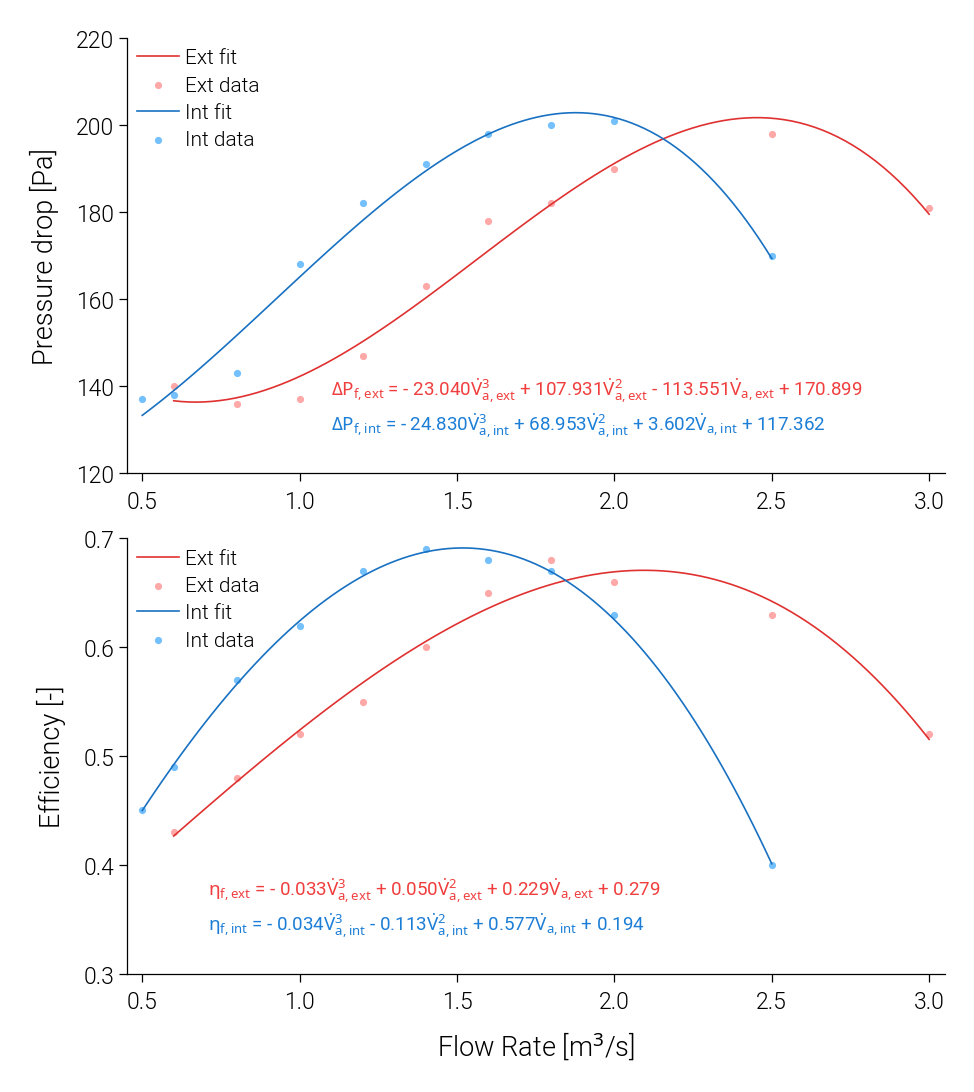

In [7]:
from scipy.optimize import curve_fit

def cubic_function(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x + d

# Parameters
fan1 = {
    'flow rate'  : [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0], # [m3/s]
    'pressure'   : [140, 136, 137, 147, 163, 178, 182, 190, 198, 181], # [Pa]
    'efficiency' : [0.43, 0.48, 0.52, 0.55, 0.60, 0.65, 0.68, 0.66, 0.63, 0.52], # [-]
}
fan2 = {
    'flow rate'  : [0.5, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5], # [m3/s]
    'pressure'   : [137, 138, 143, 168, 182, 191, 198, 200, 201, 170], # [Pa]
    'efficiency' : [0.45, 0.49, 0.57, 0.62, 0.67, 0.69, 0.68, 0.67, 0.63, 0.40], # [-]
}
fan_list = [fan1, fan2]

nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(dm.cm2in(8), dm.cm2in(9)))

for ridx in range(nrows):
    for cidx in range(ncols):
        idx = ridx * ncols + cidx
        y = ['pressure', 'efficiency', 'power'][idx]
        ylabel = ['Pressure drop [Pa]', 'Efficiency [-]', 'Power [W]'][idx]
        symbol = ['\\Delta P', '\\eta'][idx]
        
        xmin, xmax, xint, xmar = [0.5, 0.5][idx], [3, 3][idx], [0.5, 0.5][idx], [0.05, 0.05][idx]
        ymin, ymax, yint, ymar = [120, 0.3][idx], [220, 0.7][idx], [20, 0.1][idx], [0, 0][idx]

        for fidx, fan in enumerate(fan_list):
            color = ['red', 'blue'][fidx]
            label = ['Ext', 'Int'][fidx]
            sub_script = ['_{f,ext}', '_{f,int}'][idx]
            
            # fitting
            coeffs, _ = curve_fit(cubic_function, fan['flow rate'], fan[y])
            a, b, c, d = coeffs
            x_text, y_text = [0.25,0.1][idx], [0.1,0.1][idx]
            dy = [0.08,0.0][fidx]
            
            # text
            def dV(powered):
                if powered == 1:
                    return ["$\dot {V}_{a,ext}$", "$\dot {V}_{a,int}$"][fidx]
                else:
                    return ["$\dot {V}^{" + str(powered) + "}_{a,ext}$", "$\dot {V}^{" + str(powered) + "}_{a,int}$"][fidx]
            
            cur_eq = f"{'+' if a > 0 else '-'} {abs(a):.3f}{dV(3)} {'+' if b > 0 else '-'} {abs(b):.3f}{dV(2)} {'+' if c > 0 else '-'} {abs(c):.3f}{dV(1)} {'+' if d > 0 else '-'} {abs(d):.3f}"
            axes[idx].text(x_text, y_text + dy, f"${symbol}{['_{f,ext}', '_{f,int}'][fidx]}$ = {cur_eq}", transform=axes[idx].transAxes, fontsize=dm.fs(-3), color=f'dm.{color}7', fontweight=350)
            
            # get points
            flow_range = np.linspace(min(fan['flow rate']), max(fan['flow rate']), 100)
            fitted_values = cubic_function(flow_range, *coeffs)

            # plot
            axes[idx].plot(flow_range, fitted_values, label=f'{label} fit', color=f'dm.{color}8', linewidth=0.4)
            axes[idx].scatter(fan['flow rate'], fan[y], label=f'{label} data', color=f'dm.{color}3', s=1.5)

            # set x, y limits
            axes[idx].set_xlim(xmin - xmar, xmax + xmar)
            axes[idx].set_ylim(ymin - ymar, ymax + ymar)
            
            # set tick parameters
            axes[idx].tick_params(axis='x', labelsize=dm.fs(-2))
            axes[idx].tick_params(axis='y', labelsize=dm.fs(-2))
            
            # set ticks
            axes[idx].set_xticks(np.arange(xmin, xmax + xint, xint))
            axes[idx].set_yticks(np.arange(ymin, ymax + yint, yint))

            # labels
            axes[1].set_xlabel('Flow Rate [m$^3$/s]', fontsize=dm.fs(-1))
            axes[idx].set_ylabel(ylabel, fontsize=dm.fs(-1))
            axes[idx].legend(fontsize=dm.fs(-2.5))

plt.subplots_adjust(hspace=0.15)
dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
# dm.util.save_and_show(fig)
fig_name = 'fan_data_fitting'
folder_path = r'C:\betlab\00 Papers, Conferences\01 Conferences\2025\AIK 춘계학술발표\ASHP exergy analysis_SH\figure'
fig.savefig(f'{folder_path}/{fig_name}.png', dpi=600)
# plt.close()

In [143]:
# Constants
x = np.linspace(-10, 80, 100)

# Calculate EER for each value of x
COP = 5.06 - 0.05 * x + 0.00006 * x**2

# font size
label_fontsize = dm.fs(-2)
tick_fontsize = dm.fs(-2.5)

# Plot the EER graph
fig, ax = plt.subplots(figsize=(dm.cm2in(7), dm.cm2in(3)))
ax.plot(x, COP, label='COP', color='dm.red5', linewidth=0.8)

ax.set_xlabel('Temperature Difference [K]', fontweight=300)
ax.set_ylabel('COP [-]')

# tick
ax.tick_params(axis='both', which='major',)
ax.tick_params(axis='both', which='minor',)

# axis
ax.set_xlim(-10, 80)
ax.set_ylim(0.0, 6.0)

dm.simple_layout(fig, margins=(0.05, 0.05, 0.0, 0), bbox=(0, 1, 0.1, 1), verbose=False)
fig_name = 'COP-dT relationship'
folder_path = r'C:\betlab\00 Papers, Conferences\01 Conferences\2025\AIK 춘계학술발표\ASHP exergy analysis_SH\figure'
fig.savefig(f'{folder_path}/{fig_name}.png', dpi=600)

dm.save_and_show(fig)

## GB - exergy efficiency comparison according to outdoor temperature variation

In [9]:
ex_eff_list = []
X_w_serv_list = []
X_NG_list = []
for Tidx in [-20,-10,0,10,20]:
    boiler = GasBoiler()
    boiler.T0 = cu.C2K(Tidx)
    boiler.system_update()
    
    X_w_serv = boiler.exergy_balance["mixing valve"]["out"]["$X_{w,serv}$"]
    X_NG = boiler.exergy_balance["combustion chamber"]["in"]["$X_{NG}$"]
    
    ex_eff_list.append(X_w_serv / X_NG)
    X_w_serv_list.append(X_w_serv)
    X_NG_list.append(X_NG)
    
    # print(f"\n\n\n{'='*10} T0 = {Tidx} °C {'='*10}")
    # print(print_balance(boiler.exergy_balance))

In [13]:
ymin, ymax, yint = 0, 20, 5
xmin, xmax, xint = -20, 20, 10

fig, ax = plt.subplots(figsize=(dm.cm2in(9), dm.cm2in(4)))
ax.plot([-20,-10,0,10,20], np.array(ex_eff_list)*100, color='dm.red5', linewidth=0.8)
ax.set_xlabel('Outdoor air temperature [°C]', fontweight=300)
ax.set_ylabel('Exergy efficiency [%]', fontweight=300)

# x, y limits
xmar = (xmax - xmin) * 0.0
ymar = (ymax - ymin) * 0.0
ax.set_xlim(xmin - xmar, xmax - xmar)
ax.set_ylim(ymin - ymar, ymax + ymar)

# set tick
ax.set_xticks(np.arange(xmin, xmax + xint*0.9, xint))
ax.set_yticks(np.arange(ymin, ymax + yint*0.9, yint))

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0.0, 1), verbose=False)

fig_name = 'Ex_eff_T0'
folder_path = r'figure'
fig.savefig(f'{folder_path}/{fig_name}.png', dpi=600)

dm.save_and_show(fig)

plt.close()

In [ ]:
ymin, ymax, yint = 0, 3000, 1000
xmin, xmax, xint = -20, 20, 10

fig, ax = plt.subplots(figsize=(dm.cm2in(9), dm.cm2in(4)))
ax.plot([-20,-10,0,10,20], X_w_serv_list, color='dm.red5', linewidth=0.8,label='$X_{w,serv}$')
ax.plot([-20,-10,0,10,20], X_NG_list, color='dm.blue5', linewidth=0.8, label='$X_{NG}$')

ax.set_xlabel('Outdoor air temperature [°C]', fontweight=300)
ax.set_ylabel('Exergy [W]', fontweight=300)

# x, y limits
xmar = (xmax - xmin) * 0.0
ymar = (ymax - ymin) * 0.0
ax.set_xlim(xmin - xmar, xmax - xmar)
ax.set_ylim(ymin - ymar, ymax + ymar)

# set tick
ax.set_xticks(np.arange(xmin, xmax + xint*0.9, xint))
ax.set_yticks(np.arange(ymin, ymax + yint*0.9, yint))

# legend
ax.legend(fontsize=dm.fs(-2))

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0.0, 1), verbose=False)

fig_name = 'Exergy_T0'
folder_path = r'figure'
fig.savefig(f'{folder_path}/{fig_name}.png', dpi=600)

dm.save_and_show(fig)

plt.close()

: 

In [ ]:
def get_pressure_drop_of_heat_exchanger(N_tot, N_pass, beta):
        N_ch   = int((N_tot - 1) / (2 * N_pass))
        psi    = math.pi * b / lamda
        phi    = (1/6) * (1 + np.sqrt(1 + psi**2) + 4 * np.sqrt(1 + (psi**2) / 2))
        D_ex   = 2 * b / phi # m
        G_c    = dV_pmp * rho_w / (N_ch * b * L_w) # [kg/m2s]
        Re_ex  = G_c * D_ex / mu_w # 
        f_ex   = 0.8 * phi ** (1.25) * Re_ex ** (-0.25) * (beta/30) ** 3.6 # friction factor [-]
        dP_ex  = 2 * f_ex * (L_ex / D_ex) * (G_c ** 2) / rho_w # Pa